In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
from gaussian_kde import gaussian_kde
from utility import display_components,display_pca_data

Using Theano backend.


In [2]:
import holoviews as hv
hv.notebook_extension()

from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip, Hist
)

from ipywidgets import HBox, VBox, IntSlider, Play, jslink, Layout, Dropdown
import ipywidgets

In [3]:
# del display_components

In [47]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core
Treatment = "W13_only" 
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [4]:
wave = "W13_only"

BES_numeric = pd.read_hdf( BES_data_folder+"BESnumeric"+wave+".hdf", "BESnumeric"+wave )
print("BES_numeric",  BES_numeric.shape )
var_type    = pd.read_hdf( BES_data_folder+"var_type"+wave+".hdf", "var_type" )
print("var_type",  var_type.shape )
BES_reduced = pd.read_hdf( BES_data_folder+"BES_reduced"+wave+".hdf", "BES_reduced"+wave )
print("BES_reduced",  BES_reduced.shape )

fname = BES_data_folder+"cat_dictionary"+wave+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

BES_numeric (31197, 300)
var_type (312, 1)
BES_reduced (31197, 306)


In [5]:
BES_non_numeric = pd.read_hdf( BES_data_folder+"BESnon_numeric"+wave+".hdf", "BESnon_numeric"+wave )
print("BES_non_numeric",  BES_non_numeric.shape ) # BESW10non_numeric.hdf

BES_non_numeric (31197, 11)


In [6]:
BES_reduced_with_na = pd.read_hdf(BES_data_folder+"BES_reduced_with_na"+wave+".hdf","BES_reduced_with_na"+wave)
print("BES_reduced_with_na", BES_reduced_with_na.shape )

BES_reduced_with_na (31197, 306)


In [7]:
# fname = BES_data_folder+"cat_dictionaryW10"+".pkl"
# with open(fname, "rb") as f:
#     cat_dictionary = pickle.load( f )
# print("cat_dictionary", len( cat_dictionary ) )

In [8]:
# var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
# print("var_type",  var_type.shape )

In [9]:
# BES_reduced = pd.read_hdf(BES_data_folder+"BES_reducedW10.hdf","BES_reducedW10")
# print("BES_reduced",  BES_reduced.shape )

In [10]:
# BES_numeric = pd.read_hdf( BES_data_folder+"BESW10numeric.hdf", "BESW10numeric" )
# print("BES_numeric",  BES_numeric.shape )

In [11]:
# BES_non_numeric = pd.read_hdf( BES_data_folder+"BESW10non_numeric.hdf", "BESW10non_numeric" )
# print("BESW10non_numeric",  BES_non_numeric.shape ) # BESW10non_numeric.hdf

In [12]:
# BES_reduced_with_na = pd.read_hdf(BES_data_folder+"BES_reduced_with_naW10.hdf","BES_reduced_with_naW10")
# print("BES_reduced_with_na", BES_reduced_with_na.shape )

    

In [14]:
fname = BES_data_folder+"new_old_col_names"+wave+".pkl"

with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

In [70]:
# fname = BES_data_folder+"new_old_col_namesW10.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

In [9]:
# # reduce to representative core
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# BES_reduced = BES_reduced.loc[ BES_Panel['wt_core_W8'].notnull() , : ]
# BES_numeric = BES_numeric.loc[ BES_Panel['wt_core_W8'].notnull() , : ]

In [15]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

In [17]:
gc.collect()

0

In [18]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)

# (svd_solver='full', n_components='mle',whiten=True)
#decomp = PCA(svd_solver='full')
#decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
 #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# ,n_components=30

X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)

Wall time: 3.49 s


In [19]:
gc.collect()

0

In [20]:
treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = treatdir + os.sep + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = treatdir + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

In [21]:
gc.collect()

0

In [52]:
os.sep

'\\'

In [13]:
# # %%time
# # import importlib.util
# # import utility
# # importlib.reload(utility)
# # from utility import display_components

# import imp; imp.reload(utility)
# del display_pca_data
# from utility import display_pca_data

In [22]:
display_pca_data(n_components, decomp, BES_std)

average log-likelihood of all samples: -385.7318301828778
number of iterations: 2


In [15]:
# del display_components

In [16]:
# 0.07954041   0.03892755   0.03553862   0.01885494    0.01562524  
# 50.4286187   24.68006591  22.53148776  11.95403344   9.90639926

In [309]:
def display_components(n_components, decomp, folder, cols, BES_decomp):

    n_comps = min(n_components,20)
    comp_labels = {}
    comp_dict = {}

    for comp_no in range(0,n_comps):

        fig, axes = plt.subplots(ncols=2)

        ax = axes[1]
        comp = pd.DataFrame( decomp.components_[comp_no], index = cols, columns = ["components_"] )
        comp["comp_absmag"] = comp["components_"].abs()
        comp = comp.sort_values(by="comp_absmag",ascending=True)
        
        ax.set_xlabel("abs. variable coeffs")
        ax.set_title("Histogram of abs. variable coeffs")
        comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

        # set top abs_mag variable to label
        comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
        # if top abs_mag variable is negative
        if comp[-1:]["components_"].values[0] < 0:
            comp["components_"]         = -comp["components_"]
            decomp.components_[comp_no] = -decomp.components_[comp_no]
            BES_decomp[comp_no]         = -BES_decomp[comp_no]

        ax = axes[0]
        title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
        comp_labels[comp_no] = title
        ax.set_title( title )
        ax.set_xlabel("variable coeffs")
        xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
        comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6), xlim=xlim )

#         print(title)
        fname = folder + title.replace("/","_").replace(":","_") + ".png"
#         print(fname)
        fig.savefig( fname, bbox_inches='tight' )

        comp_dict[comp_no] = comp
        plt.close()
        
    return (BES_decomp, comp_labels, comp_dict)

In [55]:
(BES_decomp, comp_labels,comp_dict) = display_components(n_components, decomp, subdir + os.sep, BES_reduced.columns, BES_decomp)

In [34]:
comp_dict[0].loc["age"]

components_    0.302769
comp_absmag    0.302769
Name: age, dtype: float64

In [54]:
subdir

'../BES_analysis_data/W13_only/FactorAnalysis'

In [25]:
comp_slider = IntSlider(min=0, max=19, step=1, description='Component', value=0)
def comp_changed(change):
    comp = comp_dict[comp_slider.value]
    fig_lasso.title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"
    bar_lasso.x = comp["components_"].tail(30).index
    bar_lasso.y = comp["components_"].tail(30).values
    
comp_slider.observe(comp_changed, 'value')

comp = comp_dict[0]
x = comp["components_"].tail(30).index
y = comp["components_"].tail(30).values

In [89]:
# # returns = np.log(prices[1:]) - np.log(prices[:-1])
# hist_x = LinearScale()
# hist_y = LinearScale()
# hist = Hist(sample=comp["comp_absmag"], scales={'sample': hist_x, 'count': hist_y}, bins=30)

# hist_x.min=0
# hist_x.max=1

# h_xax = Axis(scale=hist_x, label='abs. variable coeffs', grids='off', set_ticks=True)
# h_yax = Axis(scale=hist_y, label='Freq', orientation='vertical', grid_lines='none')

# layout=ipywidgets.Layout(min_width='1000px', min_height='200px')

# fig_hist = Figure( marks=[hist], axes=[h_xax, h_yax], title='histogram of abs. variable coeffs',
#                    layout = layout, min_height='200px', preserve_aspect=False )
# fig_hist

In [26]:
from bqplot import DateScale, LinearScale, OrdinalScale, Axis, Lines, Scatter, Bars, Hist, Figure
title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"

xs, ys = OrdinalScale(), LinearScale()
ys.min = -1
ys.max = 1

data = np.arange(20)
bar_lasso = Bars(x=x, y=y, scales={'x': xs, 'y': ys}, orientation='horizontal',font_size = '30px')
xax_lasso, yax_lasso = Axis(scale=xs, orientation='vertical'), Axis(scale=ys, label='variable coeffs', orientation='horizontal')
fig_margin = dict(top=60, bottom=60, left=320, right=60)
layout=ipywidgets.Layout(min_width='1000px', min_height='600px')
fig_lasso = Figure(marks=[ bar_lasso], axes=[xax_lasso, yax_lasso],
                   title=title, fig_margin = fig_margin,
                   layout=layout)
# fig_lasso

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='center')

VBox([ fig_lasso,  comp_slider ], layout = box_layout)

In [39]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

# SparsePCA
if decomp_method == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [367]:
# BES_decomp.index
# BES_reduced.loc[BES_decomp.index,decomp_label_col].shape

In [36]:
value_selector = Dropdown(
    options=list( BES_reduced.columns ),
    value='lr_scale__Right',
    description='BES Variable:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

def value_changed(change):
    print(value_selector.value)
#     comp = comp_dict[comp_slider.value]
#     fig_lasso.title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"
#     bar_lasso.x = comp["components_"].tail(30).index
#     bar_lasso.y = comp["components_"].tail(30).values
    
value_selector.observe(value_changed, 'value')
value_selector

likeRudd__Strongly like
lr2__Strongly agree
redistGreen__Government should be less concerned about equal incomes
redistLab__Government should be less concerned about equal incomes


In [40]:
from bqplot import *
sc_x = LinearScale()
sc_y = LinearScale()
sc_col = ColorScale(colors=['red', 'white', 'green'], mid=0.0)
decomp_label_col = 'lr_scale__Right'
size = 100

x_data = BES_decomp.loc[ :, x_axis ]
y_data = BES_decomp.loc[ :, y_axis ]

scatt_1 = Scatter(x=x_data,
                  y=y_data[:50],
                  color=BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
                  scales={'x': sc_x, 'y': sc_y, 'color': sc_col})
scatt_2 = Scatter(x=x_data, y=y_data[:50] * 2, color=y_data[:50] * 2, scales={'x': sc_x, 'y': sc_y, 'color': sc_col}, 
               preserve_domain={'color': True}, marker='cross')

ax_x = Axis(scale=sc_x)
ax_y = Axis(scale=sc_y, orientation='vertical')
Figure(marks=[scatt_1, scatt_2], axes=[ax_x, ax_y])

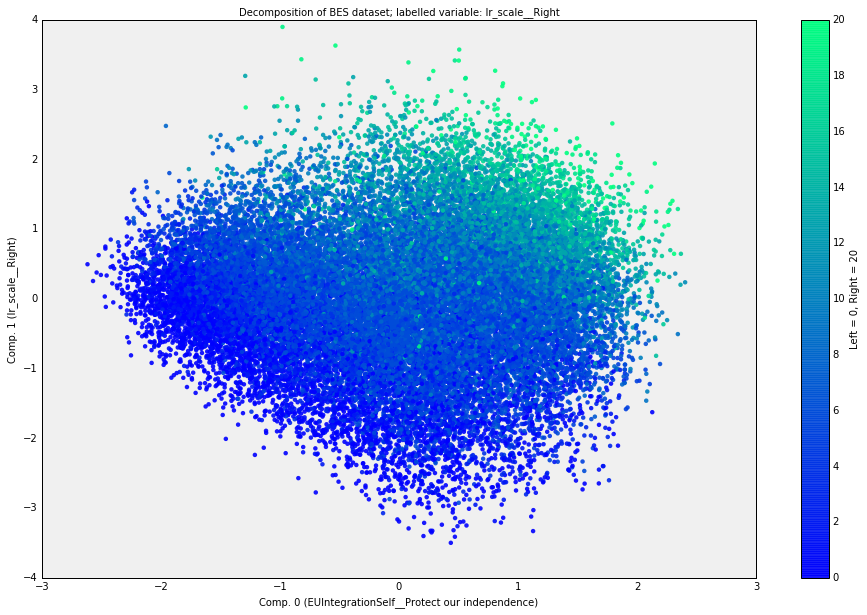

In [51]:
# for ordinal categorical
# winter, autumn
%matplotlib inline
cmap_name = "winter"
decomp_label_col = 'lr_scale__Right'
label_stub = decomp_label_col.split("__")[0]

fig = plt.figure( figsize=(16,10) )
plt.scatter(BES_decomp.loc[ :, x_axis ],
            BES_decomp.loc[ :, y_axis ],
            cmap = plt.get_cmap(cmap_name),
            c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
            edgecolor = "None",
            alpha = 0.9) #            edgecolors=col,

plt.xlim(xlim) #cats
plt.ylim(ylim)

cats = cat_dictionary[ label_stub ]
labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.show()

fig.savefig( BES_data_folder+Treatment+ os.sep +decomp_method+ os.sep +label_stub+".png", bbox_inches='tight' )

In [369]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'al_scale__Authoritarian'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

noise_variance_
lr_scale__Right                                            0.238861
likeCon__Strongly like                                     0.245644
al_scale__Authoritarian                                    0.268419
ptvCon__Very likely                                        0.275283
likeLab__Strongly like                                     0.279099
likeCorbyn__Strongly like                                  0.301439
likeMay__Strongly like                                     0.302928
EUIntegrationSelf__Protect our independence                0.314394
ptvLab__Very likely                                        0.319054
effectsEUEcon__Much better                                 0.336471
likeUKIP__Strongly like                                    0.352110
euPriorityBalance__Control immigration                     0.362791
euLeaveVoice__Much higher                                  0.381882
immigCultural__Enriches cultural life                      0.389131
asylumMore__Many more                                      0.389200
euRefVote_Leave the EU                                     0.392154
likeLD__Strongly like                                      0.397397
edlevel__Postgrad                                          0.399028
leftRight__Right                                           0.399448
generalElectionVote_Scottish National Party (SNP)          0.400169
ptvUKIP__Very likely                                       0.404580
likeGrn__Strongly like                                     0.405901
lr3__Strongly agree                                        0.409590
immigEcon__Good for economy                                0.410452
generalElectionVote_Labour                                 0.412649
age                                                        0.412883
profile_eurefvote_Leave the EU                             0.413090
effectsEUWorkers__Much better                              0.415795
likeSturgeon__Strongly like                                0.425954
likeSNP__Strongly like                                     0.426340
...                                                             ...
profile_newspaper_Other local daily morning new...         0.946351
profile_religion_Yes - Hinduism                            0.946461
profile_religion_Yes - Judaism                             0.948801
profile_religion_Yes - Evangelical  independen...         0.949602
profile_newspaper_The Scotsman                             0.950075
profile_religion_Yes - Buddhism                            0.950757
education_Recognised trade apprenticeship compl...         0.950976
profile_newspaper_The Daily Star / The Daily St...         0.954729
profile_work_stat_Working part time (Less than ...         0.954974
education_Youth training certificate/skillseekers          0.955043
voteMethoda_Someone else voted for me (proxy vo...         0.956087
bestOnMII_Other party                                      0.957093
profile_newspaper_The Financial Times                      0.957261
profile_religion_Yes - Sikhism                             0.957650
profile_ethnicity_Bangladeshi                              0.958039
profile_ethnicity_White and Black African                  0.958607
profile_religion_Yes - Baptist                             0.959564
headHouseholdPast_Someone else                             0.960285
profile_ethnicity_Other ethnic group                       0.960311
education_onc                                              0.960416
partyContactDK_Yes                                         0.962621
profile_ethnicity_Any other mixed background               0.962939
profile_ethnicity_Any other black background               0.966055
countryOfBirth_Northern Ireland                            0.967583
profile_ethnicity_White and Asian                          0.968115
profile_religion_Yes - United Reformed Church              0.969101
profile_religion_Yes - Brethren                            0.971078
profile_past_vote_2015_British National 

noise_variance_
bestOnMII_Other party                                      0.957093
countryOfBirth_Northern Ireland                            0.967583
countryOfBirth_Other: Commonwealth member country          0.935668
countryOfBirth_Other: Rest of world                        0.929187
countryOfBirth_Republic of Ireland                         0.917526
education_CSE grades 2-5                                   0.925663
education_City and Guild certificate                       0.912826
education_City and Guild certificate - advanced            0.944919
education_Clerical and commercial                          0.922013
education_Nursing qualification (eg SEN, SRN, S...         0.942879
education_Recognised trade apprenticeship compl...         0.950976
education_Scottish Ordinary/ Lower Certificate             0.914224
education_Teaching qualification (not degree)              0.921603
education_University diploma                               0.920477
education_Youth training certificate/skillseekers          0.955043
education_onc                                              0.960416
gor_East Midlands                                          0.918259
gor_North East                                             0.938410
gor_West Midlands                                          0.912159
gor_Yorkshire and the Humber                               0.904698
headHouseholdPast_My mother                                0.923238
headHouseholdPast_No one in my house worked                0.945049
headHouseholdPast_Someone else                             0.960285
housing_It belongs to a Housing Association                0.904112
pContactEday_99_Yes                                        0.922419
partyContactDK_Yes                                         0.962621
partyContactLab_7_Yes                                      0.906190
partyContactNone_Yes                                       0.936891
partyContactOtherParty_Yes                                 0.927338
profile_ethnicity_Any other Asian background               0.933907
...                                                             ...
profile_ethnicity_White and Asian                          0.968115
profile_ethnicity_White and Black African                  0.958607
profile_ethnicity_White and Black Caribbean                0.973016
profile_newspaper_Other Newspaper                          0.920142
profile_newspaper_Other local daily morning new...         0.946351
profile_newspaper_The Daily Star / The Daily St...         0.954729
profile_newspaper_The Express                              0.940189
profile_newspaper_The Financial Times                      0.957261
profile_newspaper_The Herald (Glasgow)                     0.926892
profile_newspaper_The Independent                          0.944871
profile_newspaper_The Scotsman                             0.950075
profile_past_vote_2015_British National Party (...         0.971416
profile_religion_Yes - Baptist                             0.959564
profile_religion_Yes - Brethren                            0.971078
profile_religion_Yes - Buddhism                            0.950757
profile_religion_Yes - Evangelical  independen...         0.949602
profile_religion_Yes - Free Presbyterian                   0.973130
profile_religion_Yes - Hinduism                            0.946461
profile_religion_Yes - Judaism                             0.948801
profile_religion_Yes - Methodist                           0.934505
profile_religion_Yes - Other                               0.943194
profile_religion_Yes - Sikhism                             0.957650
profile_religion_Yes - United Reformed Church              0.969101
profile_religion_Yes  Orthodox Christian                  0.935485
profile_work_stat_Unemployed                               0.907731
profile_work_stat_Working part time (Less than ...         0.954974
reasonForVote_None of these                                0.923081
registered_No                           

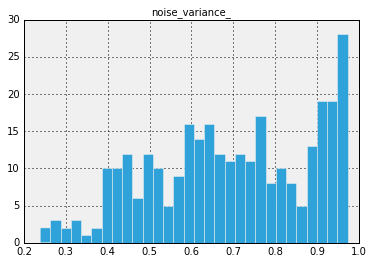

In [42]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [371]:
# # who are the "improbables"?

# if hasattr(decomp, 'score_samples'):
#     most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
#     least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
#     print("least likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)<least_likely] ])
# # who are the "stereotypes"?
#     print("most likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)>most_likely ] ])
# # check to see balance of missing values!

In [90]:
gc.collect()

0

In [88]:
X[:,0:2].shape

(31197, 2)

In [100]:

# affinity_propagation = cluster.AffinityPropagation(damping=.9,
#                                                    preference=-200)

# affinity_propagation.fit(X[:,0:2])

# dbscan = cluster.DBSCAN(eps=.2)
# dbscan.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

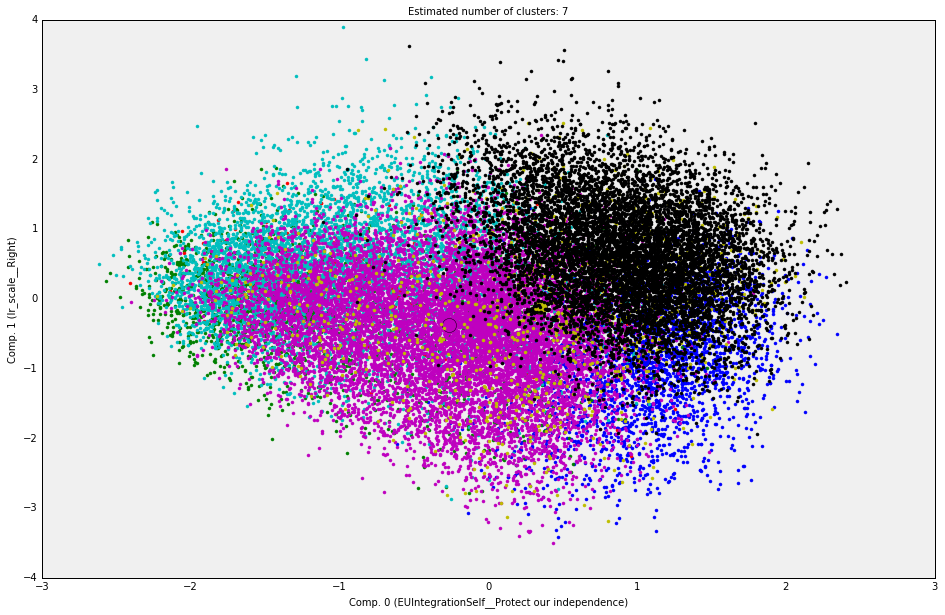

In [114]:
from sklearn import cluster
X = X_r

two_means = cluster.MiniBatchKMeans(n_clusters=7)
two_means.fit(X)

labels = two_means.labels_
cluster_centers = two_means.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)

In [107]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [111]:
labels, centroids, X_hat = kmeans_missing(BES_reduced_with_na, n_clusters=5)

C:\ANACON~1\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


MemoryError: 

In [110]:
gc.collect()

0

number of estimated clusters : 1
Wall time: 860 ms


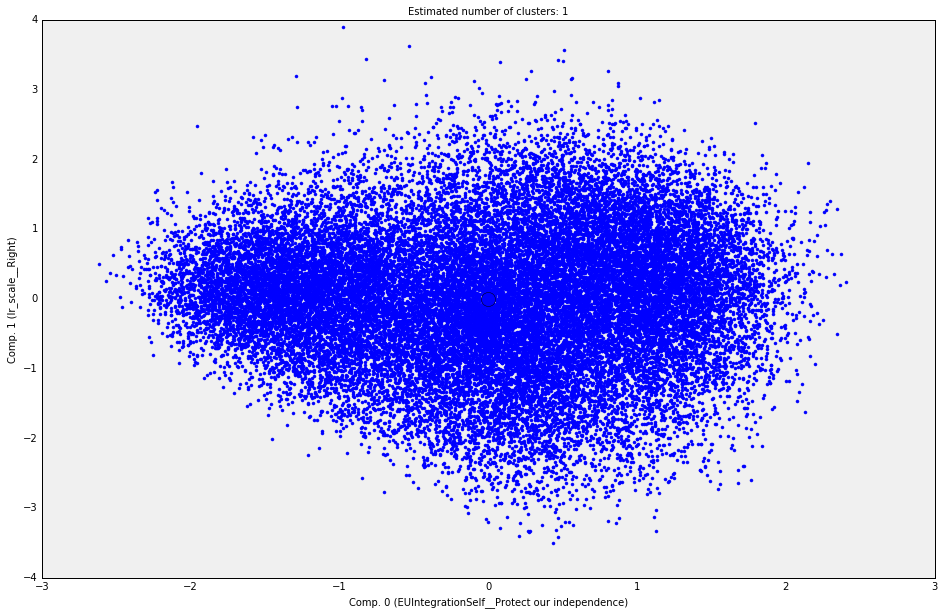

In [82]:
%%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(BES_data_folder+Treatment+ os.sep +decomp_method+ os.sep +"Cluster_estimation.png",bbox_inches='tight')


In [56]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

In [374]:
# BES_reduced.columns

In [375]:
# BES_Panel["riskScale"]

In [376]:
# [ x for x in BES_reduced.columns if re.match(decomp_label_col + "(__)?", x) ]

# # re.match(decomp_label_col + "__", )

C:\ANACON~1\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


age
personality_agreeableness
personality_conscientiousness
personality_extraversion
personality_neuroticism
personality_openness


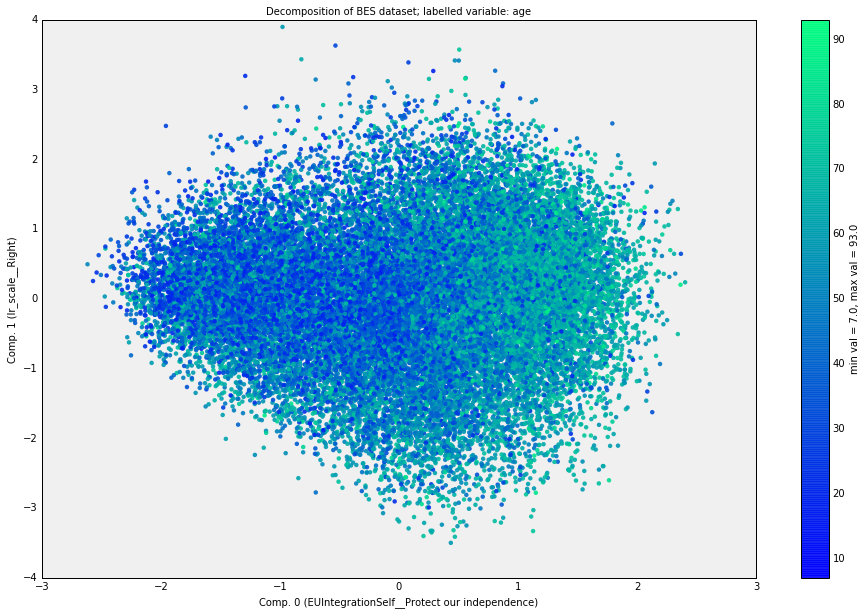

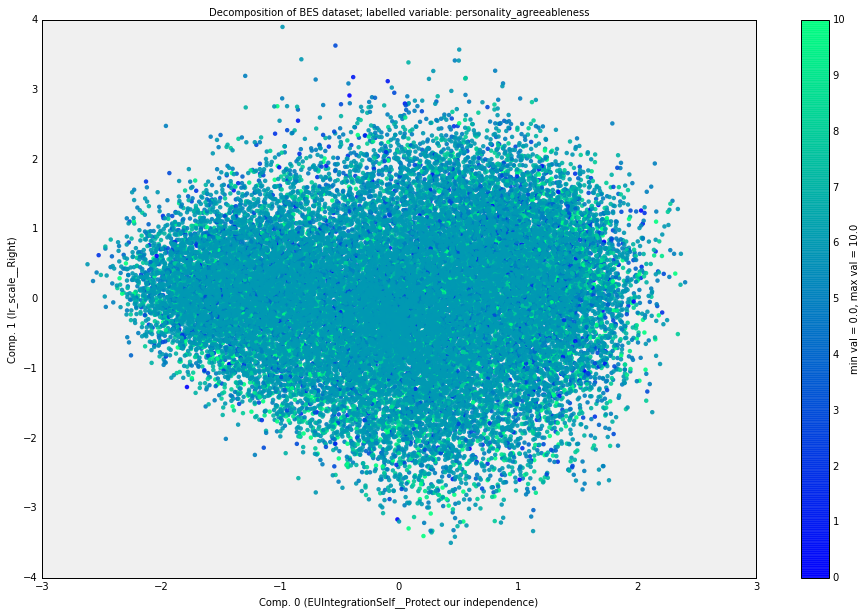

In [66]:
# %%time

graph_type = "ordinal_scatter/"
folder = BES_data_folder+Treatment +os.sep+ decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    

cmap_name = "winter"
    
dummy_list = var_type[ [ x in [ 0, 1, 2, 5, 6 ] for x in var_type["type"]  ] ].index # 0, 1, 2, 5, 6.index # ordinal variables

# ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:

#     if decomp_label_col in ["profile_religion","country",
#                             'polKnowMay','polKnowOsborne',
#                             'polKnowClegg', 'polKnowBercow',
#                             'polKnowMiliband', 'registered', 'ns_sec']:
#         continue
    
    fig = plt.figure( figsize=(16,10) )

#     # go through all the variables that have been created from base variables through transformation
#     # for ordinal variables, these should only ever be unique matches (unlike non-ordinals)
#     decomp_label_categories = [ x for x in BES_reduced.columns if re.match(decomp_label_col + "_?_?", x) ]
#     if len(decomp_label_categories) == 0: # removed during transformation/reduction
#         continue
#     elif len(decomp_label_categories) > 1:
#         raise Exception('len(decomp_label_categories) > 1 !!!')
#     # c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
    
    #### NEEDS FIXING!!!
    
    if (decomp_label_col not in BES_reduced.columns):
        if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
            decomp_label_categories = new_old_col_names[decomp_label_col]
        else:
            continue ## variable removed in transformation
    else:
        decomp_label_categories = decomp_label_col
    
    label_stub = decomp_label_col

    plt.scatter(BES_decomp.loc[ :, x_axis ],
                BES_decomp.loc[ :, y_axis ],
                cmap = plt.get_cmap(cmap_name),
                c = BES_reduced.loc[ BES_decomp.index , decomp_label_categories],
                edgecolor = "None",
                alpha = 0.9) #            edgecolors=col,

    plt.xlim(xlim)
    plt.ylim(ylim)

    # get category labels for categorical variables
    if var_type.loc[label_stub,"type"] in [ 1, 2, 5 ]: #6 already numerical
        cats = cat_dictionary[ label_stub ]
        labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    elif var_type.loc[label_stub,"type"] in [ 0, 6 ]:
        vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories]
        labels = ( "min val", min(vals), "max val", max(vals) )
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')
        
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
    plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
#     plt.show()
    print(decomp_label_col)
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1
#     print(fig_no)

Wall time: 16.7 s


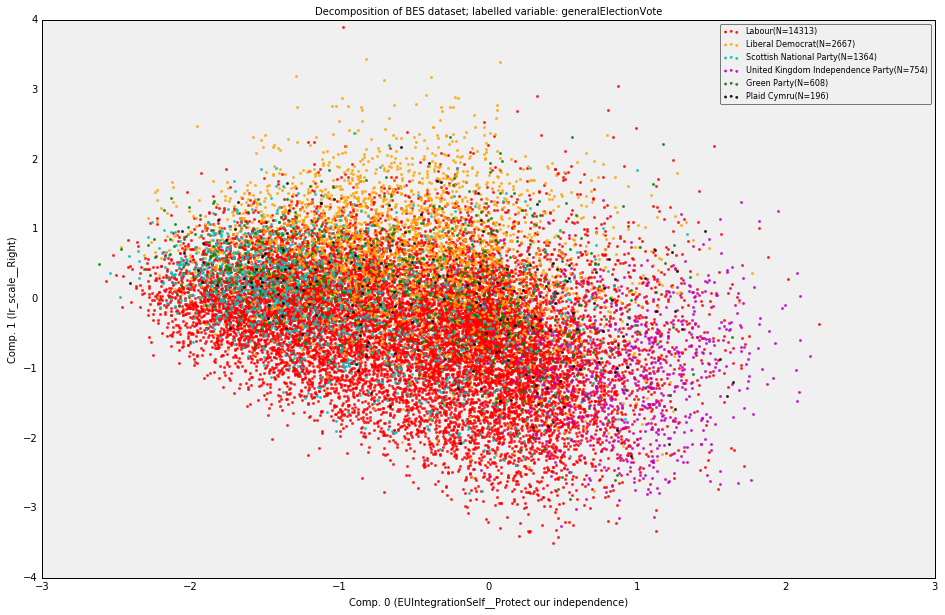

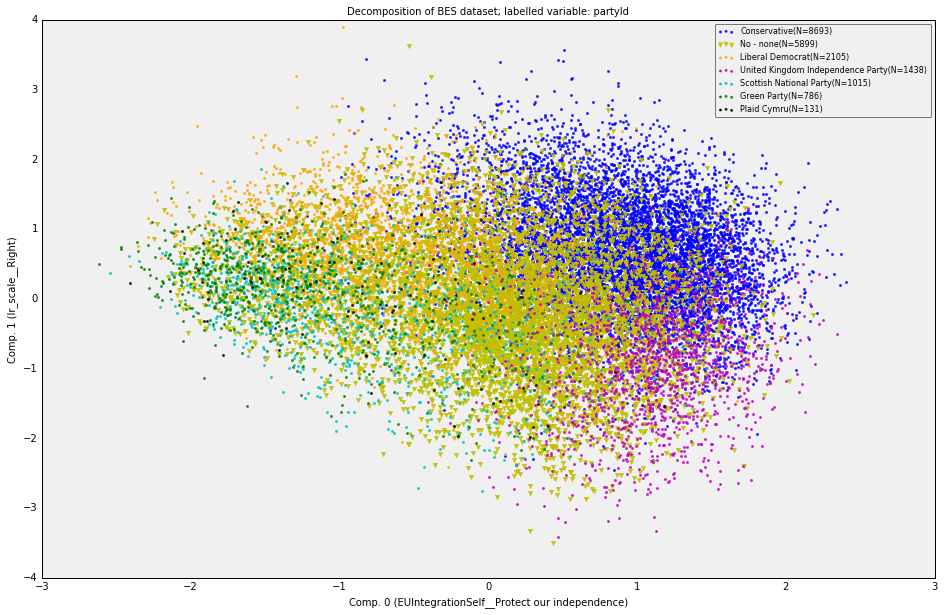

In [68]:
%%time

graph_type = "non_ordinal_scatter/"
folder = BES_data_folder +os.sep+ Treatment +os.sep+ decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue
        
#     if (decomp_label_col not in BES_reduced.columns):
#         if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
#             decomp_label_categories = new_old_col_names[decomp_label_col]
#         else:
#             continue ## variable removed in transformation
#     else:
#         decomp_label_categories = decomp_label_col        

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [379]:
# col = "euRefVote"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# # add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# # make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

# # plt.xlim(xlim)
# # plt.ylim(ylim)   
# # plt.xlim(-3, 3)  
# # plt.ylim(-3, 3)

# # labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')

# # save to file
# g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')

In [380]:
# BES_numeric['riskScale'].astype('category')
# df[col].value_counts()
# [str(x) for x in df[col].cat.categories]
# df[col].value_counts().values

Wall time: 1min 49s


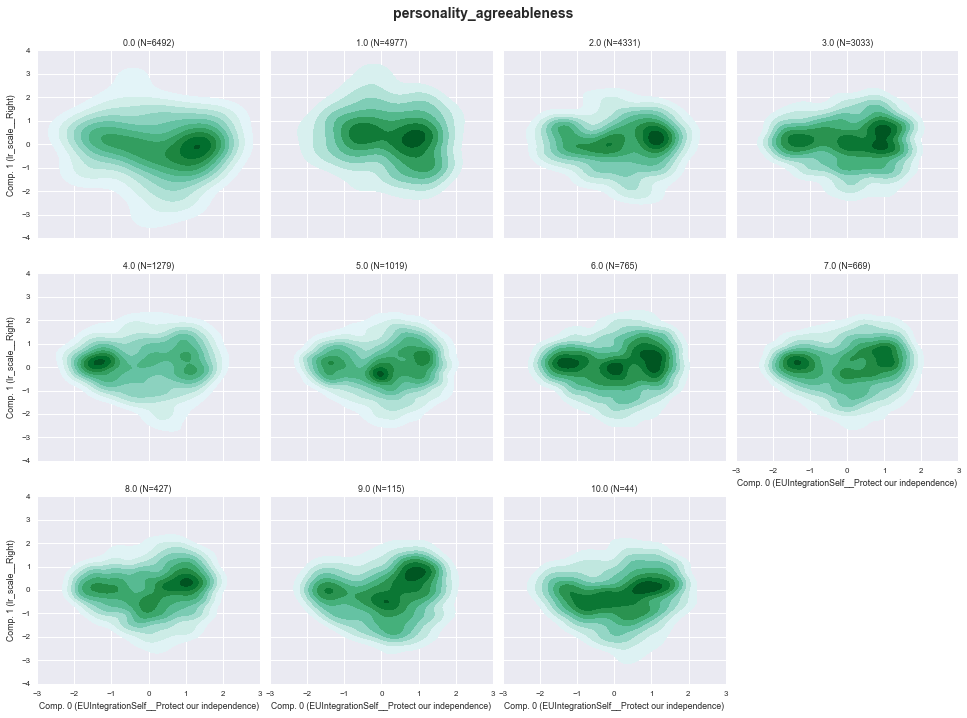

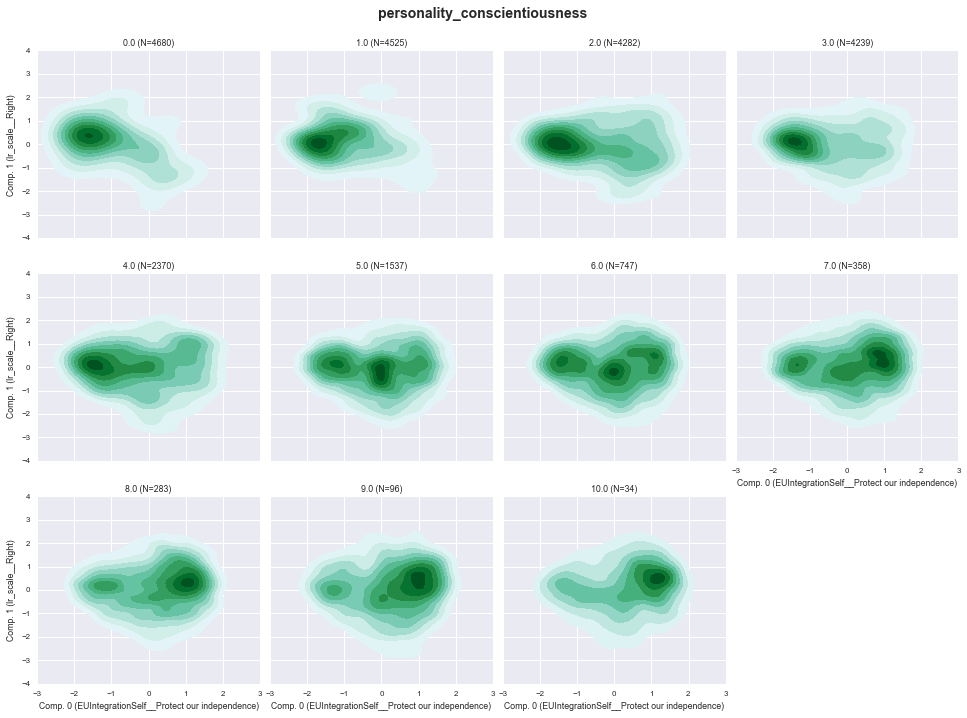

In [117]:
%%time

graph_type = "ordinal_kde/"
folder = BES_data_folder +os.sep+ Treatment +os.sep+ decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ [ x in [ 0 ] for x in var_type["type"]  ] ].index # , 1, 2, 5, 6

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

#     # get category labels for categorical variables
#     if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
#         cats = cat_dictionary[ label_stub ]
#         labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
#     elif var_type.loc[label_stub,"type"] in [ 0 ]:
#         vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
#         labels = ( "min val", min(vals), "max val", max(vals) )
#     else:
#         raise Exception('var_type not in [ 0, 1, 2, 5, 6]')    
    
    if var_type.loc[col,"type"] in [ 1, 2, 5, 6 ]:
    
        # reduce length of subcategories
        cats = list(cat_dictionary[col])
        for catno in range( len( cats ) ):

            words = cats[catno].split(" ")
            word_array = np.array( [len(x) for x in words] ) + 1
            max_words = np.where( np.cumsum( word_array )<30 )[0].max()
            cats[catno] = " ".join( words[0:max_words+1] )
        # NOTE - can cause problems if 2+ truncated subcategories are identical

        # add a category column to split the graphs on
        df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().loc[cats].values        
    elif var_type.loc[col,"type"] in [ 0 ]:
        df[col] = BES_numeric[col].astype('category')
        cats = [str(x) for x in df[col].cat.categories]
        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().values          
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')          
        

    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder +os.sep+ col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

ValueError: Categorical categories must be unique

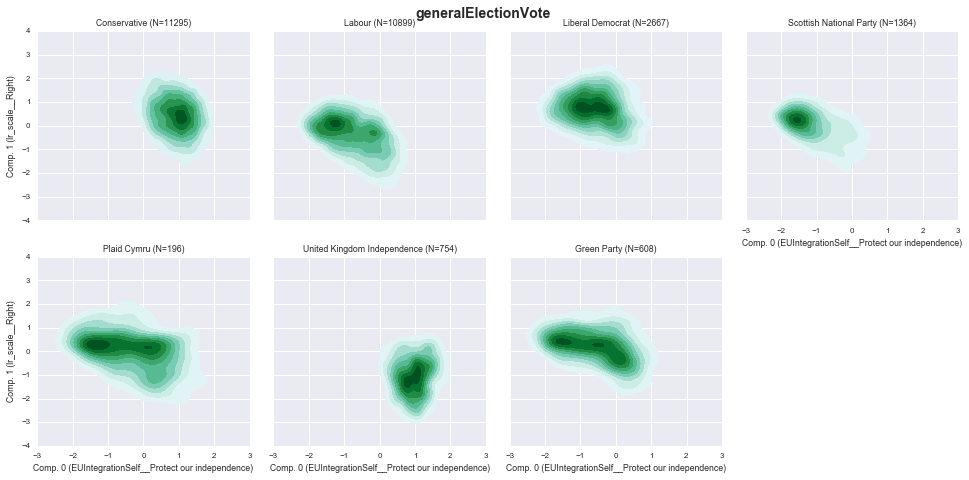

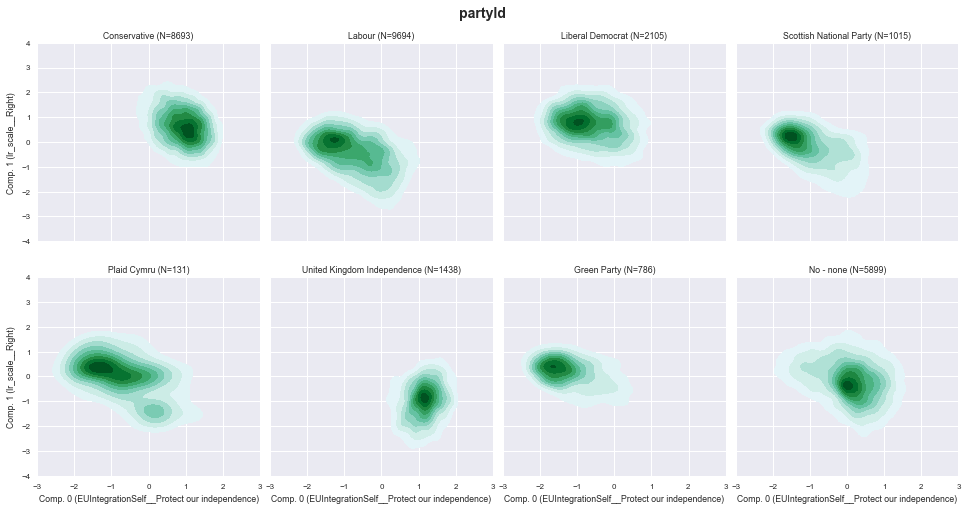

In [118]:
%%time
# 10 minutes!
graph_type = "non_ordinal_kde/"
folder = BES_data_folder +os.sep+ Treatment +os.sep+ decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

    # reduce length of subcategories
    cats = list(cat_dictionary[col])
    for catno in range( len( cats ) ):

        words = cats[catno].split(" ")
        word_array = np.array( [len(x) for x in words] ) + 1
        max_words = np.where( np.cumsum( word_array )<30 )[0].max()
        cats[catno] = " ".join( words[0:max_words+1] )
    # NOTE - can cause problems if 2+ truncated subcategories are identical

    # add a category column to split the graphs on
    df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

    # add N=??? sample size to each category type!
    sample_sizes = df[col].value_counts().loc[cats].values
    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder +os.sep+ col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

Wall time: 23 s


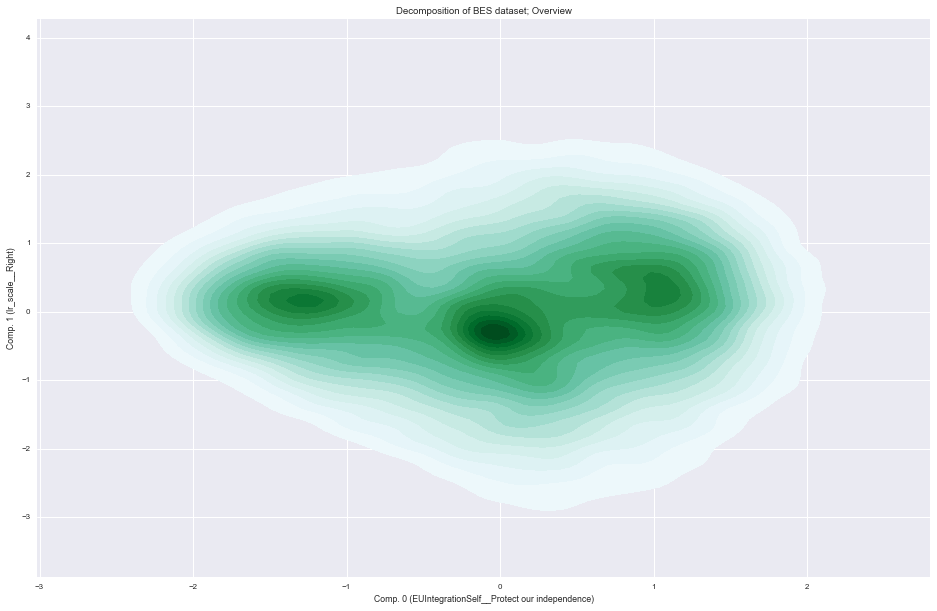

In [119]:
%%time
# col = "edlevel"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
fig = plt.figure( figsize=(16,10) )
sns.kdeplot(BES_decomp.loc[ : , [x_axis,y_axis] ],
            shade=True, shade_lowest=False, n_levels=20) #, shade=True, shade_lowest=False)
# g.set_titles("{col_name}")

# plt.xlim(xlim)
# plt.ylim(ylim)   
# plt.xlim(-3, 3)  
# plt.ylim(-3, 3)

# labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Decomposition of BES dataset; Overview')
# save to file
fig.savefig(BES_data_folder + os.sep + Treatment + os.sep + decomp_method + os.sep + "overview"+"_kde", bbox_inches='tight')

In [384]:
# %%time
# # Load BES Panel for Wave 8
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# #(31409, 733)

# # BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

# print( BES_Panel.shape )

In [385]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
# print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

In [386]:
# #create mesh grid
# x = np.linspace(xlim[0], xlim[1], 100)
# y = np.linspace(ylim[0], ylim[1], 100)
# xx, yy = np.meshgrid(x, y)

In [387]:
# #Evaluate the kde on a grid
# pdf = gaussian_kde(samples.values, weights=weights.values)
# zz = pdf((np.ravel(xx), np.ravel(yy)))
# zz = np.reshape(zz, xx.shape)

In [388]:
# gc.collect()

In [389]:
# kwargs = dict(extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='hot', origin='lower')

In [390]:
# plt.figure()
# plt.imshow(zz, **kwargs)
# plt.title('kde')
# plt.tight_layout()
# plt.show()

In [391]:
# from matplotlib import mlab, cm
# levels = np.arange(0, 0.16, 0.01)  # Boost the upper limit to avoid truncation errors.
# norm = cm.colors.Normalize(vmax=abs(zz).max(), vmin=-abs(zz).max())
# cmap = cm.PRGn
# cset1 = plt.contourf(xx, yy, zz, levels,
#                  cmap=cm.get_cmap(cmap, len(levels) - 1),
#                  norm=norm,
#                  )

In [120]:
(x_axis,y_axis,xlim,ylim)

(0, 1, (-3.0, 3.0), (-4.0, 4.0))

In [121]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
weights = BES_Panel['wt_core_W8'].dropna()
print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)

(20404,)
(2, 20266)


In [122]:
%%time
weighted_kde(xlim, ylim, samples, weights)

NameError: name 'weighted_kde' is not defined

In [ ]:
gc.collect()

In [ ]:
comp_labels

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

# https://github.com/jakevdp/wpca
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb
from wpca import PCA, WPCA, EMPCA

In [43]:
BES_non_numeric['wt_full_W10']

0        0.086091
1        0.741154
2        8.693233
3        0.208183
4        0.636257
5        0.414223
6        0.960867
7        0.516427
8        0.791542
9        2.092525
10       0.164776
11       0.416674
12       0.621170
13       0.207278
14       0.963819
15       0.864958
16       0.964619
17       0.201780
18       1.258211
19       0.578333
20       2.032674
21       0.174617
22       0.618020
23       0.664999
24       1.390832
25       1.030952
26       0.158081
27       0.269150
28       0.917177
29       0.125920
           ...   
30289    0.577613
30290    0.790683
30291    0.654091
30292    0.601757
30293    0.683266
30294    0.343598
30295    1.277012
30296    1.784475
30297    1.398531
30298    1.599030
30299    0.795376
30300    1.416771
30301    0.868663
30302    0.405567
30303    5.169990
30304    0.398592
30305    6.585568
30306    1.490326
30307    0.853384
30308    2.513149
30309    0.509086
30310    0.406830
30311    4.359217
30312    0.848451
30313    0

In [289]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
row_weights = BES_non_numeric['wt_new_W13'].copy()#.dropna()
#BES_Panel['wt_full_W8'].dropna()

# there's a nan right at this point and nowhere else!
row_weights.loc[5987] = 1.0

print(row_weights.shape)

# # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

(31197,)


In [399]:
# thresh = .2
# counts = BES_numeric.count()
# mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
# # mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])

# many_cat_drop_list = ['Age', 'EUMIICategory', 'age', 'country_of_residence1',
#        'country_of_residence2', 'euRefExpectation', 'ns_sec', 'pano',
#        'profile_lea', 'profile_oslaua']

# high_corr_drop_list = ['ageGroup', 'euRefVote2', 'euRefVotePost', 'euRefVoteUnsqueeze',
#        'recallVote15', 'voted2015']

# very_low_var = ['partyContactLD_6', 'partyContactLD_7', 'partyContactUKIP_1']

# BES_reduced = BES_numeric.copy()
# BES_reduced.drop(W9_vars,               axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(mostly_not_filled_out, axis=1, inplace=True, errors='ignore')
# # BES_reduced.drop(many_cat_drop_list   , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(high_corr_drop_list  , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(very_low_var         , axis=1, inplace=True, errors='ignore')
# print(BES_reduced.shape)

In [290]:
BES_reduced_with_na.shape

(31197, 306)

In [291]:
# subsample
# BES_reduced = BES_reduced_with_na[BES_reduced_with_na.columns[0:200]][0:30000].copy()

BES_reduced = BES_reduced_with_na.copy()
# BES_reduced = BES_reduced.copy()

In [292]:
# multiply binary null/notnull matrix by the weights for each row (individual)
weights = BES_reduced.notnull().astype('int').apply(lambda x: x*row_weights)
# weights = BES_reduced.notnull().astype('int') # just missing values

In [293]:
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.fillna(0).values )

In [294]:
# "weightPCAreduced_withPP/" - 2% reduced data
# "weightPCAreduced_withPP/"
# Treatment = "weightPCAuptodate"
# Treatment = "sklearnPCAuptodate"
# Treatment = "weightPCAuptodate_weights_just_missing_values"
# Treatment = "EMPCAuptodate_weights_just_missing_values"
# Treatment = "EMPCA_W10_only"
Treatment = "WPCA_W13_only"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [296]:
# %%time
from wpca import PCA, WPCA, EMPCA
# from sklearn.decomposition import PCA
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# decomp = PCA(svd_solver='full')
# #decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#  #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# # decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
# #
# # alpha=2 -> 1hr
# decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# # ,n_components=30
# PCA, WPCA, EMPCA
# decomp = PCA(n_components=10)
# decomp = EMPCA() # overnight!
# decomp = WPCA() # 21 minutes, 7min 54s (14min 34s) -> rubbish
# decomp = WPCA(n_components=10) # 6.2s -> rubbish
# decomp = WPCA(n_components=30) # 7min 22s -> rubbish
# decomp = EMPCA(n_components=10) # 6.2s # 20min 29s -> and rubbish
#decomp = EMPCA() # more than 8 hours - had to interrupt
# weights = []
decomp = WPCA() #332ms # (n_components=30)
# 20s with weights, 7mins with no weights (weird!)
# decomp = EMPCA()

# decomp = PCA() # svd_solver='full' # 2s

# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0:
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


In [297]:
Treatment
#EMPCAuptodate_weights_just_missing_values

'WPCA_W13_only'

In [298]:
decomp_method = str(decomp).split("(")[0]

subdir = BES_data_folder+"/"+Treatment+"/"+decomp_method+"/"
if not os.path.exists(subdir): os.makedirs(subdir)


explained variance ratio (first 30): [ 0.07190578  0.04836582  0.04016466  0.0304535   0.02301868  0.01958906
  0.01878876  0.01821714  0.0167784   0.01531082  0.01469063  0.01443072
  0.01349279  0.01306375  0.01232054  0.01079997  0.01072767  0.00987271
  0.00945183  0.00889837  0.0086591   0.00852873  0.00837054  0.00822427
  0.00791568  0.00784489  0.00761567  0.00747046  0.00717685  0.00707487]
explained variance (first 30): [ 27.91036524  18.77328249  15.58998989  11.82058436   8.93474246
   7.60352995   7.29289067   7.07101884   6.51256574   5.94292504
   5.70219647   5.60131071   5.23724993   5.07071899   4.7822394
   4.19203016   4.16396684   3.83211128   3.66874379   3.45391813
   3.36104667   3.31044145   3.24904087   3.19226648   3.07248772
   3.04500944   2.95603726   2.899672     2.7857078    2.74612249]


TypeError: There is no Line2D property "figsize"

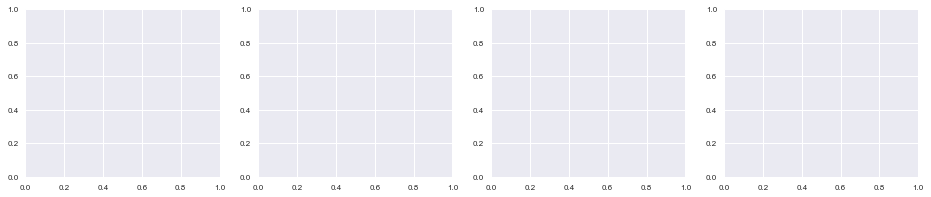

In [299]:
display_pca_data(n_components, decomp, BES_std)

In [308]:
%%time
# BES_decomp, comp_labels, comp_dict = display_components(n_components, decomp, subdir, BES_reduced.columns, BES_decomp)
(BES_decomp, comp_labels,comp_dict) = display_components(n_components, decomp, subdir + os.sep, BES_reduced.columns, BES_decomp)

Comp. 0 (profile_ethnicity_Black African)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 0 (profile_ethnicity_Black African).png
Comp. 1 (profile_ethnicity_Black African)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 1 (profile_ethnicity_Black African).png
Comp. 2 (profile_ethnicity_Black Caribbean)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 2 (profile_ethnicity_Black Caribbean).png
Comp. 3 (profile_turnout_2015_Yes, voted)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 3 (profile_turnout_2015_Yes, voted).png
Comp. 4 (partyContactDK_Yes)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 4 (partyContactDK_Yes).png
Comp. 5 (profile_ethnicity_Any other black background)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 5 (profile_ethnicity_Any other black background).png
Comp. 6 (profile_ethnicity_Bangladeshi)
../BES_analysis_data//WPCA_W13_only/WPCA/\Comp. 6 (profile_ethnicity_Bangladeshi).png
Comp. 7 (profile_ethnicity_Any other black background)
../BES_analysis_data//WPCA_W13_only

In [302]:
gc.collect()

356163

In [303]:
decomp

WPCA(n_components=None, regularization=None, xi=0)

In [11]:
W5vars = [x for x in BES_reduced.columns if "W5" in x]

In [12]:
len(W5vars)

210

In [92]:
# W5corr = BES_non_numeric["CampaignDayW5"].corr( BES_reduced[W5vars] )
W5corr = BES_reduced[W5vars].corrwith(BES_non_numeric["CampaignDayW5"])
# BES_non_numeric["CampaignDayW5"].corr(  )

In [129]:
W5corr.sort_values(ascending=False)

partyContact1W5_Yes                                                                      0.509568
debateTwoWatchW5_Yes                                                                     0.431721
conPartnerSNPW5_Would join Conservatives                                                 0.169797
discussPolDaysW5__7 days                                                                 0.130770
participation_5W5_Yes                                                                    0.106097
infoSourcePeopleW5__More than 2 hours                                                    0.085568
generalElectionCertaintyW5__Completely certain                                           0.077574
participation_3W5_Yes                                                                    0.063199
bestLeaderCampaignW5_Nicola Sturgeon                                                     0.056842
conPartnerUKIPW5_Would join Conservatives                                                0.053938
participation_6W5_Ye

In [100]:
var_list = W5corr.abs().sort_values(ascending=False).head(60).index

In [39]:
[x for x in BES_reduced.columns if "likeBennett" in x]


['likeBennettW4__Strongly like',
 'likeBennettW5__Strongly like',
 'likeBennettW6__Strongly like',
 'likeBennettW7__Strongly like',
 'likeBennettW8__Strongly like',
 'likeBennettW9__Strongly like']

b':Curve   [Campaign Day]   (likeBennettW5__Strongly like)'
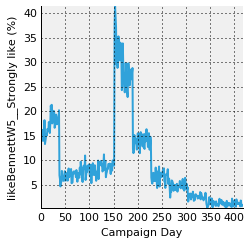

In [44]:
variable = 'likeBennettW5__Strongly like'
# "labPartnerSNPW5_Would join Labour"
crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                       columns = BES_reduced[ variable ],
                       values  = BES_non_numeric[ "wt_daily_W5" ],
                       aggfunc = sum,
                       normalize='index')

x_axis = "Campaign Day"
y_axis = variable
x_dim = hv.Dimension(x_axis, values = crosstab.index)
y_dim = hv.Dimension(y_axis, unit = '%')#, soft_range = (0,100))
hv.Curve(crosstab.unstack() * 100,
                           kdims = [x_dim] ,
                           vdims = [y_dim] )

In [84]:
( x for x in zip(range(0, int(BES_reduced[ variable ].max())),crosstab.columns) )

<generator object <genexpr> at 0x000000000DBD43B8>

b':HoloMap   [$variable$]\n   :Curve   [$x$]   ($\\phi(x;stuff)$)'
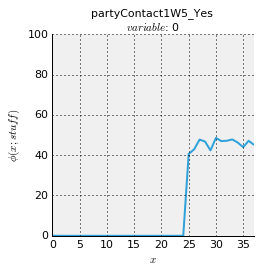
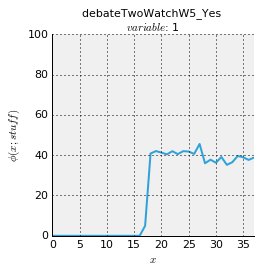
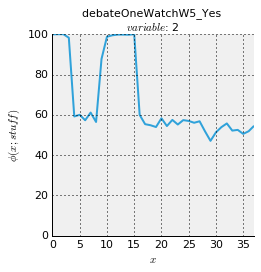
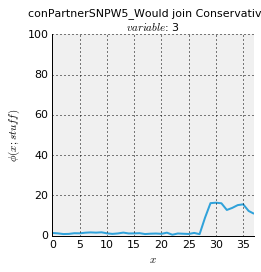
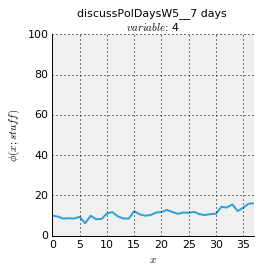
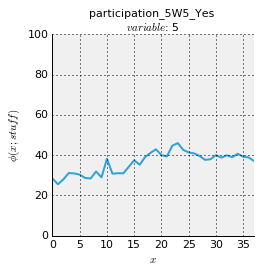
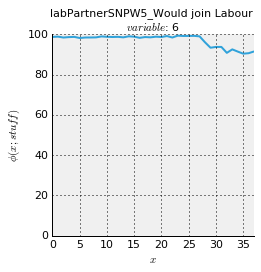
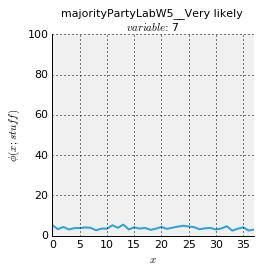
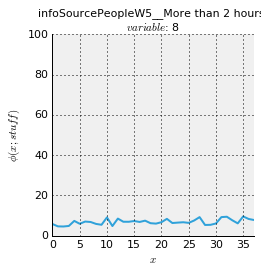
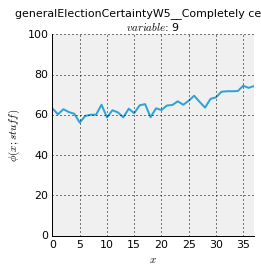
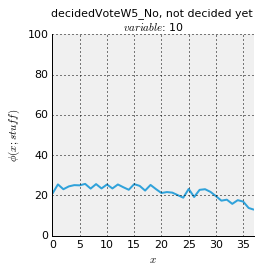
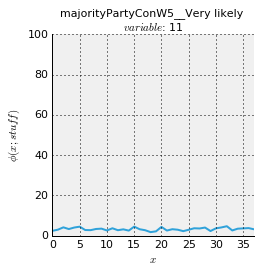
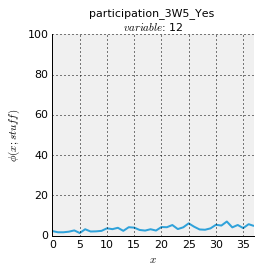
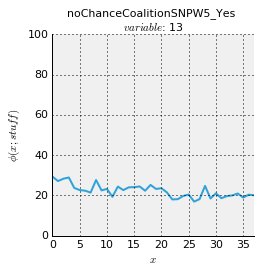
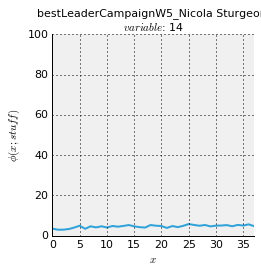
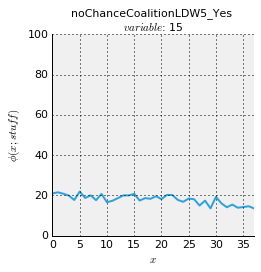
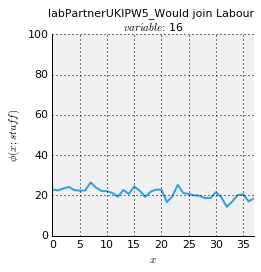
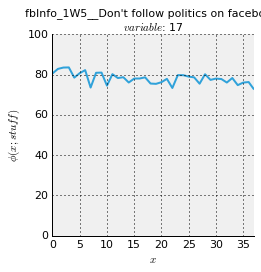
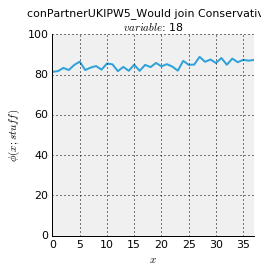
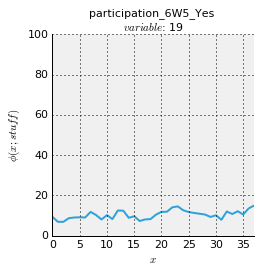
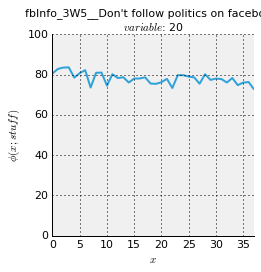
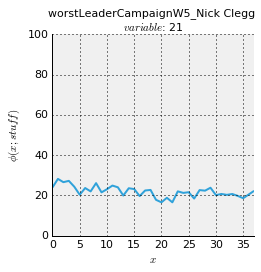
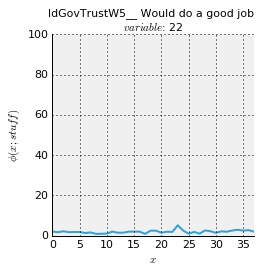
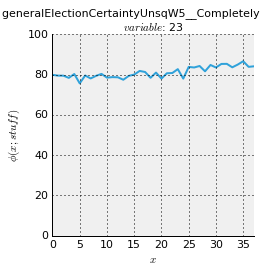
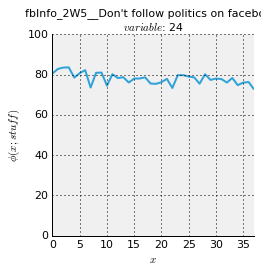
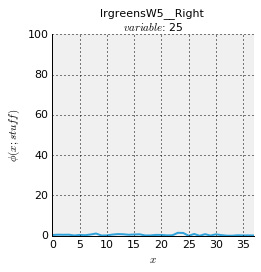
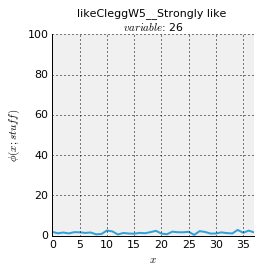
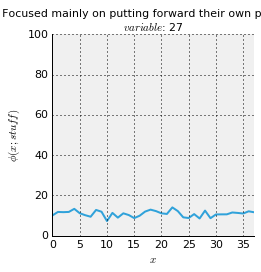
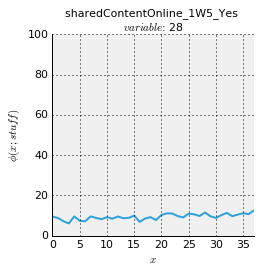
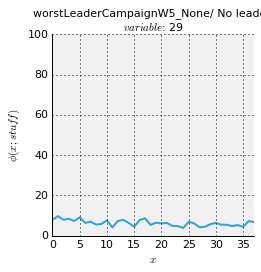
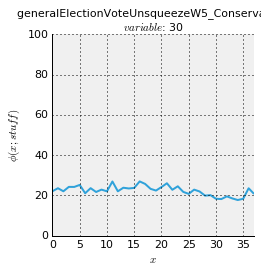
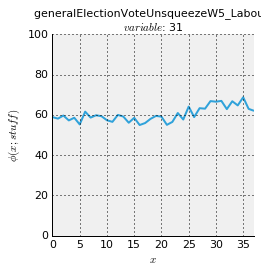
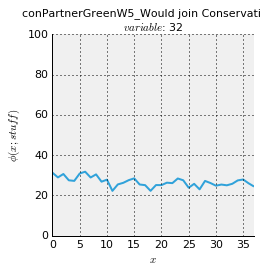
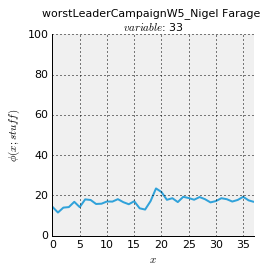
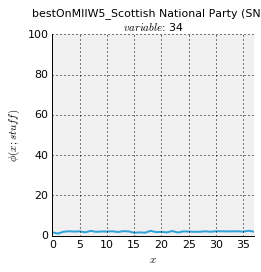
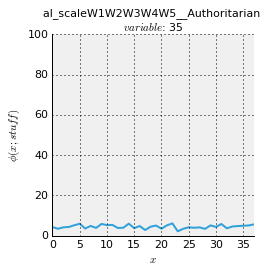
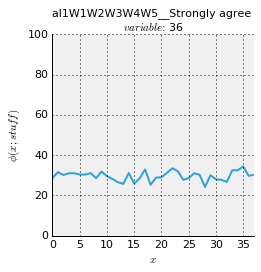
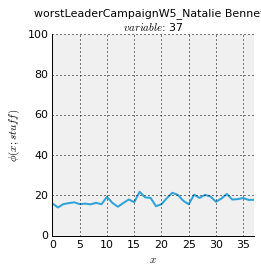
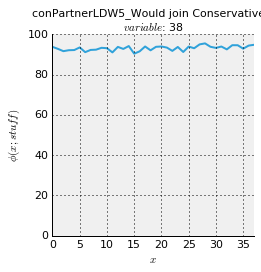
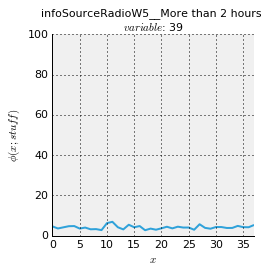
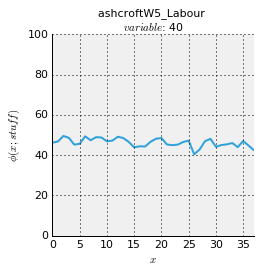
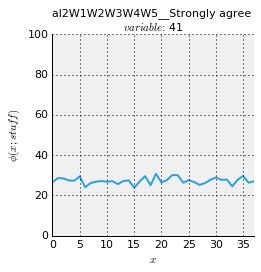
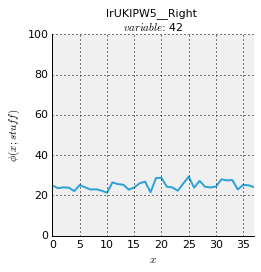
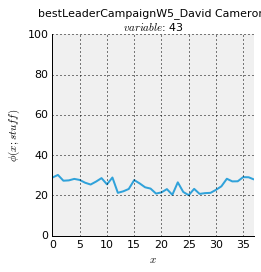
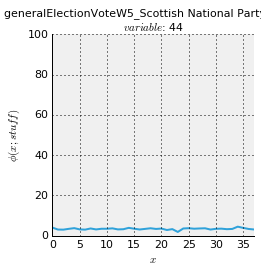
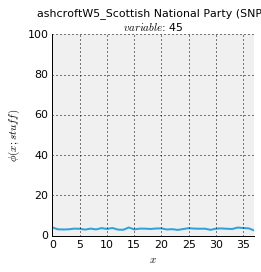
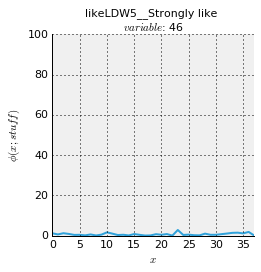
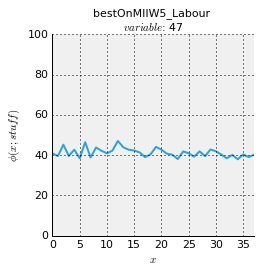
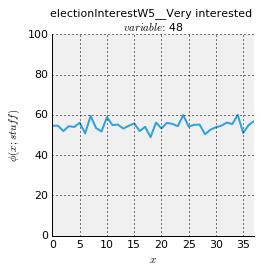
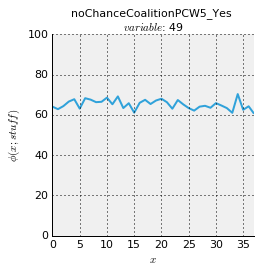
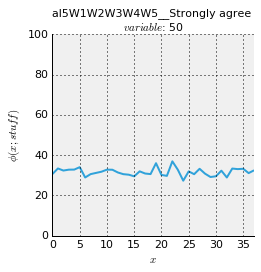
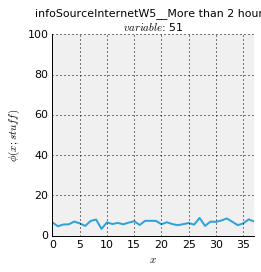
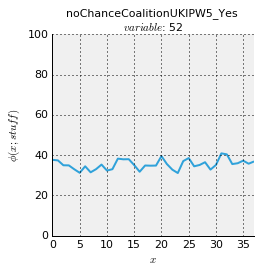
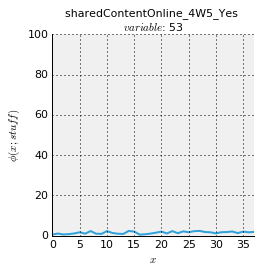
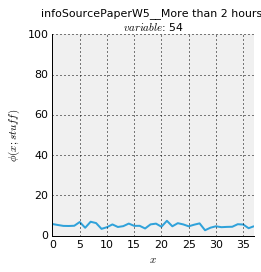
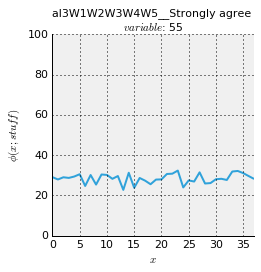
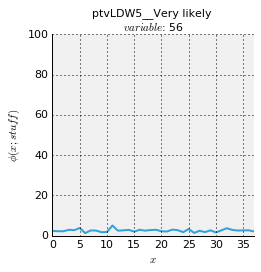
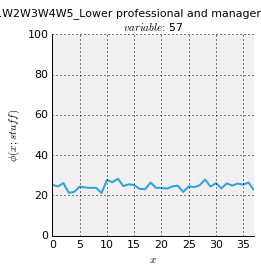
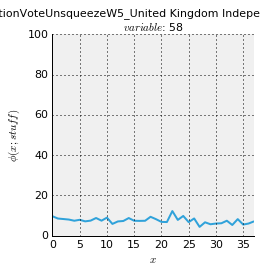
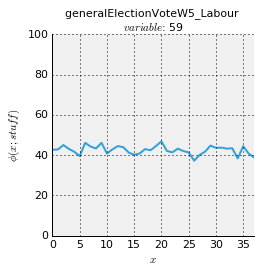

In [139]:
hmap_of_curves =  hv.HoloMap(kdims=['$variable$'])

# var_list = ['likeBennettW5__Strongly like', "labPartnerSNPW5_Would join Labour"]
var_list = W5corr.abs().sort_values(ascending=False).head(60).index

for var_no in range(len(var_list)):
#     print(variable)
    variable = var_list[var_no]

    crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                           columns = BES_reduced[ variable ],
                           values  = BES_non_numeric[ "wt_daily_W5" ],
                           aggfunc = sum,
                           normalize='index')
#     crosstab.columns = cat_dictionary[new_old_col_names[variable]]    

#     curves = hv.NdOverlay(key_dimensions=['$stuff$'] )
    
#     for value in range(0, 1+int(BES_reduced[ variable ].max()) ):
# #         col_variable = crosstab.columns[value]
#         curves[value] = hv.Curve(crosstab[value]*100,
#                                 kdims=['$x$'],
#                                 vdims=['$\\phi(x;stuff)$'], label = variable) 
#     hmap_of_curves[var_no] = curves
    col_variable = int(BES_reduced[ variable ].max())
    hmap_of_curves[var_no] = hv.Curve( crosstab[col_variable] * 100,
                                kdims=['$x$'],
                                vdims=['$\\phi(x;stuff)$'], label = variable)
    
hmap_of_curves

In [123]:
    crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                           columns = BES_reduced[ 'noChanceCoalitionLDW5_Yes' ],
                           values  = BES_non_numeric[ "wt_daily_W5" ],
                           aggfunc = sum,
                           normalize='index')

In [144]:
[x for x in BES_reduced.columns if "Age" in x]

[]